c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn

MLP Cross-Validation Results:
Accuracy: 0.4625 (+/- 0.0289)
Log-loss: 4.6808 (+/- 0.5360)
F1-score: 0.4398 (+/- 0.0315)

SVM Cross-Validation Results:
Accuracy: 0.2248 (+/- 0.0292)
Log-loss: 3.5097 (+/- 0.0353)
F1-score: 0.1885 (+/- 0.0340)

MLP chosen as the best model.


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(



Test Set Results:
Accuracy: 0.4597
Log-loss: 4.7557
F1-score: 0.4400


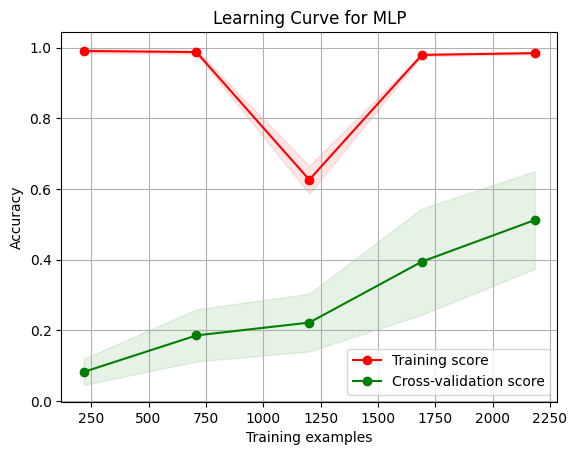

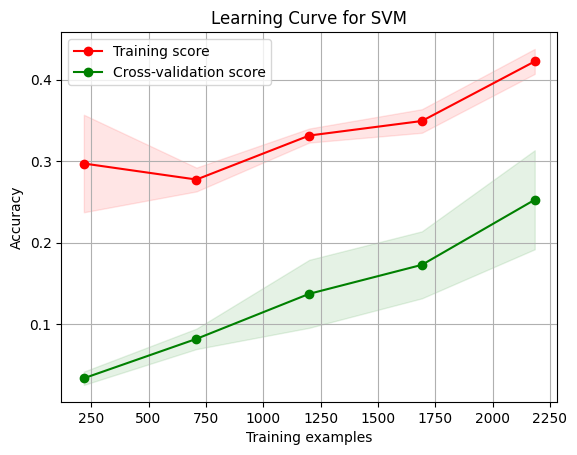

In [3]:
# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting
from sklearn.model_selection import train_test_split, cross_validate, learning_curve  # For model evaluation
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.neural_network import MLPClassifier  # For Multi-Layer Perceptron classifier
from sklearn.svm import SVC  # For Support Vector Machine classifier
from sklearn.pipeline import make_pipeline  # For creating a pipeline of transformations
from sklearn.metrics import accuracy_score, log_loss, f1_score  # For model evaluation metrics

# Load and preprocess the data 
data = pd.read_csv('resampled_dataset.csv')  # Read the CSV file
X = data.iloc[:, :-1].values / 255.0  # Extract features and normalize to [0, 1] range
y = data.iloc[:, -1].values  # Extract target variable

# Split the data into training and test sets
# use stratification (stratify=y) to ensure that the class distribution is maintained in both sets, which is crucial for imbalanced datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create models
# use make_pipeline to create a pipeline that first scales the data and then applies the classifier
mlp = make_pipeline(StandardScaler(), MLPClassifier(random_state=42, max_iter=1000))  # MLP with standardization
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42, probability=True))  # SVM with standardization

# Define scoring metrics for cross-validation
scoring = ['accuracy', 'neg_log_loss', 'f1_weighted']

# Function to perform cross-validation
def perform_cv(model, X, y, scoring):
    scores = cross_validate(model, X, y, scoring=scoring, cv=5, return_estimator=True)
    return scores

# Perform cross-validation for both models
mlp_scores = perform_cv(mlp, X_train, y_train, scoring)
svm_scores = perform_cv(svm, X_train, y_train, scoring)

# Function to print cross-validation results (accuracy, log-loss, and F1-score) for a given model 
def print_cv_results(model_name, scores):
    print(f"{model_name} Cross-Validation Results:")
    # υπολογίζει τη μέση ακρίβεια από όλες τις επαναλήψεις της crorss-validation folds , και εμφανίζει επίσης ένα διάστημα εμπιστοσύνης 95%, το οποίο μας δείχνει πόσο 
    # πιθανό είναι η πραγματική ακρίβεια να βρίσκεται εντός αυτού του εύρους.
    print(f"Accuracy: {scores['test_accuracy'].mean():.4f} (+/- {scores['test_accuracy'].std() * 2:.4f})")
    # long-loss : μετρά πόσο "εκτός" είναι οι προβλέψεις μας από τις πραγματικές τιμές. Όσο χαμηλότερη είναι η τιμή log-loss, τόσο καλύτερη είναι η απόδοση του μοντέλου. 
    # Και πάλι, ο κώδικας υπολογίζει τον μέσο όρο και το διάστημα εμπιστοσύνης 95% για να μας δώσει μια πιο ολοκληρωμένη εικόνα.
    print(f"Log-loss: {-scores['test_neg_log_loss'].mean():.4f} (+/- {scores['test_neg_log_loss'].std() * 2:.4f})")
    #F1-score: είναι ένας συνδυασμός της precision (πόσο ακριβείς είναι οι θετικές προβλέψεις μας) και της recall (πόσες από τις πραγματικές θετικές περιπτώσεις εντοπίσαμε). 
    # Το F1-score είναι ιδιαίτερα χρήσιμο όταν έχουμε ανισορροπημένα σύνολα δεδομένων.  Ο κώδικας υπολογίζει τον "weighted" F1-score, ο οποίος λαμβάνει υπόψη τη συχνότητα κάθε 
    # κατηγορίας στις προβλέψεις. Και πάλι, υπολογίζονται ο μέσος όρος και το διάστημα εμπιστοσύνης.
    print(f"F1-score: {scores['test_f1_weighted'].mean():.4f} (+/- {scores['test_f1_weighted'].std() * 2:.4f})")
    print()

# Print cross-validation results for both models (accuracy, log-loss, and F1-score) 
print_cv_results("MLP", mlp_scores)
print_cv_results("SVM", svm_scores)

# Choose the best model based on cross-validation accuracy scores and print the result 
if mlp_scores['test_accuracy'].mean() > svm_scores['test_accuracy'].mean():
    best_model = mlp
    print("MLP chosen as the best model.")
else:
    best_model = svm
    print("SVM chosen as the best model.")

# Retrain the chosen model on the entire training set and evaluate on the test set to get final results 
best_model.fit(X_train, y_train)

# Evaluate on the test set using the best model chosen from cross-validation results and print the results on the test set (accuracy, log-loss, and F1-score) 
y_pred = best_model.predict(X_test)  # Make predictions
y_pred_proba = best_model.predict_proba(X_test)  # Get prediction probabilities

# Print test set results (accuracy, log-loss, and F1-score) 
print("\nTest Set Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Log-loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Function to plot learning curves for a given model 
def plot_learning_curve(model, X, y, title):
    # δημιουργώ έναν πίνακα με 5 ισαπέχοντα σημεία από 0.1 έως 1.0,
    train_sizes = np.linspace(0.1, 1.0, 5)  
    # υπολογίζω την καμπύλη μάθησης χρησιμοποιώντας την συνάρτηση learning_curve του scikit-learn. 
    # υπολογίζει τα σκόρ εκπαίδευσης και ελέγχου για κάθε μέγεθος εκπαίδευσης και επιστρέφει τα αποτελέσματα σε έναν πίνακα.
    # χρησιμοποιεί 5 cross-validation folds και την ακρίβεια ως μετρική αξιολόγησης.
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=train_sizes, scoring='accuracy'
    )
    
    # Υπολογίζει τον μέσο όρο και την τυπική απόκλιση των σκορ εκπαίδευσης και ελέγχου για κάθε μέγεθος συνόλου εκπαίδευσης.
    # training scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    # test scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Δημιουργία νέου γράφηματος
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.grid()
    
    # Σχεδιάζει τις ζώνες σφάλματος (± 1 τυπική απόκλιση) για τα σκορ εκπαίδευσης (κόκκινο) και ελέγχου (πράσινο).
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Σχεδιάζει τις καμπύλες μάθησης για τα σκορ εκπαίδευσης και ελέγχου.
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

# Plot learning curves for both models
plot_learning_curve(mlp, X, y, "Learning Curve for MLP")
plot_learning_curve(svm, X, y, "Learning Curve for SVM")
plt.show()  # Display the plots

## Important Notes 

- Normalization 255.0 : 

Υπάρχουν αρκετοί λόγοι γιατί χρησιμοποιείτεαι κανονικοποιήση . Από τους κυριότερους είναι ότι χρησιμοποιούμε MLP μοντέλο που στο κομμάτι της Gradient Descent Optimization , τα νευρωνικά δίκτυα χρησιμοποιούν την κάθοδο κλίσης για να μάθουν.  Όταν τα χαρακτηριστικά έχουν πολύ διαφορετικές κλίμακες, μπορεί να δημιουργηθεί μια "απότομη" επιφάνεια σφάλματος, καθιστώντας δυσκολότερη τη σύγκλιση του αλγορίθμου σε μια βέλτιστη λύση. Η κανονικοποίηση βοηθά στην εξομάλυνση της επιφάνειας σφάλματος, οδηγώντας σε ταχύτερη και σταθερότερη μάθηση.

Επίσης για το μοντέλο SVM που ανήκοει στους αλγορίθμους βασισμένοι στην απόσταση βασίζονται σε υπολογισμούς απόστασης. Εάν ένα χαρακτηριστικό έχει πολύ μεγαλύτερο εύρος, θα κυριαρχήσει στον υπολογισμό της απόστασης, διαστρεβλώνοντας τις πραγματικές σχέσεις μεταξύ των σημείων δεδομένων. Η κανονικοποίηση εξασφαλίζει ότι όλα τα χαρακτηριστικά συμβάλλουν εξίσου στους υπολογισμούς απόστασης.

Ο κύριος λόγος είναι να διασφαλιστεί ότι η κατεύθυνση του διανύσματος του δείγματος είναι πιο σημαντική από το μέγεθός του.

- - Υπολογίζεται από τον τύπο : Normalized Value = (Original Value - Minimum Value) / (Maximum Value - Minimum Value) , δηλαδή σαν παράδειγμα :για RGB1_R με τιμή 229.  
RGB1_R = (229 - 0) / (255 - 0) = 0.898

- StandardScale() : 

Η τυποποίηση μετατρέπει τα δεδομένα σας έτσι ώστε να έχουν μέση τιμή 0 και τυπική απόκλιση 1. Αυτό επιτυγχάνεται αφαιρώντας τον μέσο όρο του χαρακτηριστικού από κάθε τιμή και στη συνέχεια διαιρώντας με την τυπική απόκλιση.

- - Με μαθηματικό τύπο : X' = (X - μ) / σ , όπου X: Η αρχική τιμή του χαρακτηριστικού , μ: Ο μέσος όρος (mean) όλων των τιμών του χαρακτηριστικού , σ: Η τυπική απόκλιση (standard deviation) όλων των τιμών του χαρακτηριστικού και X': Η τυποποιημένη τιμή του χαρακτηριστικού.

- - Πώς λειτουργεί ο τύπος : 

Κεντράρισμα: Αφαιρώντας τον μέσο όρο (μ) από κάθε τιμή, μετατοπίζουμε όλες τις τιμές έτσι ώστε ο νέος μέσος όρος να είναι το 0. Αυτό σημαίνει ότι οι τιμές που ήταν μεγαλύτερες από τον μέσο όρο θα γίνουν θετικές, ενώ οι τιμές που ήταν μικρότερες από τον μέσο όρο θα γίνουν αρνητικές. 
Κλιμάκωση: Διαιρώντας με την τυπική απόκλιση (σ), αλλάζουμε την κλίμακα των τιμών έτσι ώστε η νέα τυπική απόκλιση να είναι 1. Αυτό σημαίνει ότι οι τιμές που ήταν πολύ μακριά από τον μέσο όρο θα "συμπιεστούν" προς το κέντρο, ενώ οι τιμές που ήταν κοντά στον μέσο όρο θα "απλωθούν" λίγο περισσότερο.

Είναι απαίτηση κάποιων αλγορίθμων όπως του SVM , καθώς υποθέτουν ότι τα δεδομένα εισόδου είναι τυποποιημένα. 

Όταν τα χαρακτηριστικά έχουν πολύ διαφορετικές κλίμακες, εκείνα με τις μεγαλύτερες τιμές μπορεί να κυριαρχήσουν στην εκπαίδευση του μοντέλου. Η κλιμάκωση βοηθά στην αποφυγή αυτού του προβλήματος. Η τυποποίηση εξασφαλίζει ότι όλα τα χαρακτηριστικά έχουν μέση τιμή 0 και τυπική απόκλιση 1, δίνοντάς τους έτσι ίση βαρύτητα κατά την εκπαίδευση του μοντέλου.
Αντίστοιχα είναι καλό για να μην η παρουσία ακραίων τιμών ποκαλέσει κάποιο πρόβλημα . 


